# Whole Slide Imaging (WSI) and Breast Cancer Detection

---

Welcome to Tutorial 4! In this session, you will learn about the preparation and preprocessing of Whole Slide Images (WSIs), which are commonly used as input data for many pathological machine learning problems. By the end of this tutorial, you'll be challenged to build your own neural network model.

### Notebook Structure 📚

1. Whole Slide Imaging (WSI) 🖼️
2. HER2 Tumor Dataset 🧬
3. Data Exploration 🗂️
4. Data Preprocessing 🔧
5. WSI Dataset 🧠
6. Wrap It Up! 🎯

**Authors:**<br>
&copy; 2024; Jakub Pekár, Vít Musil


# 1. Whole Slide Imaging (WSI) 🖼️

---

In digital pathology, many AI applications use images of tissue samples to detect important features, such as the presence of cancer. These images are typically captured using specialized scanners in a process known as **Whole Slide Imaging (WSI)**.

### What is Whole Slide Imaging? 🔬

Whole Slide Imaging is a method of scanning tissue samples at high resolution through a microscope. The result is a detailed, high-quality digital image of the entire tissue sample. When we talk about "WSI," it could refer to both the process and the resulting image, called a **Whole Slide Image**.

### Different Formats of WSI 📂

WSI images come in **various formats**, each with its own characteristics. Common formats include:

- **SVS**
- **NDPI**
- **BigTIFF**

In this tutorial, we'll be working **exclusively with BigTIFF files**.

### Why BigTIFF? 🗂️

For handling large images like WSI, the **BigTIFF** format is ideal. It’s a variation of the traditional TIFF format but with one major advantage: it supports **64-bit offsets**. This allows it to store much larger images compared to the standard TIFF format, which has a 4GB file size limit. This makes BigTIFF perfect for the high-resolution WSI files we'll be using.

### Pyramid Structure for Large Images 🏔️

WSI images are often **huge**, sometimes reaching hundreds of thousands of pixels in height and width. To manage these large files efficiently, they are stored in a **pyramid structure**:

- Each level is a lower-resolution version of the previous one (similar to zooming out of a map 🗺️).
- The base level has the full resolution, while higher levels show a downsampled version.

There is no standard for how many levels there are or the exact downsampling factors between them.

---

### Working with xOpat Viewer 🖥️

In this tutorial, we’ll be using **xOpat**, an online viewer specifically designed for viewing Whole Slide Images (WSIs). It was developed by the **RationAI lab** and is tailored for handling the large, multi-level images typical in digital pathology.

To get familiar with the viewer, try it out with this [example](https://biomedai-summer-xopat.dyn.cloud.e-infra.cz/xopat/#%7B%22params%22%3A%7B%22bypassCookies%22%3Atrue%2C%22bypassCacheLoadTime%22%3Atrue%2C%22viewport%22%3A%7B%22zoomLevel%22%3A0.8999999999999999%2C%22point%22%3A%7B%22x%22%3A1.0555555555555556%2C%22y%22%3A0.25391820998968745%7D%7D%7D%2C%22meta%22%3A%7B%22session%22%3A%22%2Fhub%2FBreastCancer%2Fslides%2FO09-03495.tiff%22%7D%2C%22data%22%3A%5B%22%2Fhub%2FBreastCancer%2Fslides%2FO09-03495.tiff%22%5D%2C%22background%22%3A%5B%7B%22dataReference%22%3A0%2C%22lossless%22%3Afalse%7D%5D%2C%22visualizations%22%3A%5B%5D%2C%22plugins%22%3A%7B%22hotkeys%22%3A%7B%7D%2C%22user-session%22%3A%7B%7D%2C%22youtrack-feedback%22%3A%7B%7D%7D%7D).

#### Login Credentials for xOpat:

- **Username**: biomedai
- **Password**: biomedaischool2024

With xOpat, you'll be able to smoothly zoom in and out of WSIs, just like exploring a digital map. This will help you visualize and interact with the tissue samples we’ll be working on throughout the tutorial.

> **Important Note:**  
> If you want to share the slide you're currently viewing in xOpat, make sure to use the **share button** in the viewer. **Copying the URL directly** from your browser won't work!


## 2. HER2 Tumor Dataset 🧬

---

The slide you just explored in the xOpat viewer is part of the **HER2 tumor dataset**.

### What is HER2? 🤔

**HER2** (Human Epidermal Growth Factor Receptor 2) is a protein that can affect the growth of breast cancer cells. Some breast cancers have too much HER2 (HER2-positive), while others do not (HER2-negative). Identifying the HER2 status of tumors is important for diagnosis and treatment.

### The HER2 Tumor Dataset 📊

The **HER2 tumor dataset** contains digitized slides of **both HER2-positive and HER2-negative breast cancer tissue samples**. These slides are stained using the **Hematoxylin and Eosin (H&E) method**, which helps highlight different structures within the tissues. The Whole Slide Images (WSIs) in this dataset are stored in **BigTIFF** format to handle their large size and high resolution.

The dataset also includes **XML annotations** that mark regions of interest (ROIs) in the slides. These annotations highlight specific areas within the tissue that are important for detecting cancer.

### What We’ll Be Doing 🧑‍💻

In this tutorial, we’ll use these WSIs and annotations to build a **neural network (NN) model**. The goal is to train the model to automatically detect the presence of cancer in specific regions of the tissue, helping in the analysis of breast cancer cases.

Before we start, let's install the required libraries:


In [1]:
!pip install pyvips pandas openslide-python pillow albumentations matplotlib \
    git+https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/visualization.git \
    git+https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/tiling.git \
    git+https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/mlkit.git

  Cloning https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/visualization.git to /tmp/pip-req-build-6c890vf6
  Running command git clone --filter=blob:none --quiet https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/visualization.git /tmp/pip-req-build-6c890vf6
  Resolved https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/visualization.git to commit a176635930624a308c1d812ab0dfaab3312a50cf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/tiling.git to /tmp/pip-req-build-dmhqk0i6
  Running command git clone --filter=blob:none --quiet https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/tiling.git /tmp/pip-req-build-dmhqk0i6
  Resolved https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/tiling.git to commit e4df2676413ea10f7577954cc8580544c5d72e6b
  Installing build dep

## 3. Data Exploration 🗂️

---

The dataset contains a total of **85 Whole Slide Images (WSIs)**, with each slide featuring at least one tissue sample. The dataset is organized into two main folders:

- **Slides**: Contains WSIs in **BigTIFF** format.
- **Annotations**: Contains XML files with annotations that mark the **regions of interest (ROIs)** in the tissue samples.

Each WSI is paired with its corresponding annotation file based on the file name, making it easy to match slides and their ROIs.

To explore the data, you can use the [xOpat viewer](https://biomedai-summer-xopat.dyn.cloud.e-infra.cz/index.php?p=hub%2FBreastCancer). However, please note that the **XML annotations are viewable only as text**.

As mentioned earlier, we can't directly feed these raw WSIs into a NN model. The images are too large and complex, so we’ll need to perform some **preprocessing** first!


## 4. Data Preprocessing 🔧

---

As you may have noticed while exploring the WSIs, a large part of each image is just **background** with no valuable tissue information. This makes it inefficient to process the entire image, especially when training machine learning models. To focus only on the relevant tissue areas, we’ll create a **binary tissue mask**.

### Step 1: Creating a Binary Tissue Mask 🛠️

A **binary tissue mask** is a black-and-white image that helps us separate tissue from background:

- **White (1)** represents the tissue regions.
- **Black (0)** represents the background.

Your first task will be to write a script that generates a tissue mask for each WSI. But at what level (pyramidal resolution) should we generate the mask?

In most cases, it’s not necessary to create the mask at the highest resolution (the base level with no downsampling). Since the mask doesn’t need to be extremely precise, it can include a bit of background as long as it covers all the tissue. Typically, we start at a **higher WSI level** (a lower-resolution version of the slide) and then go lower until further downsampling doesn’t significantly improve the mask.

To decide the best level for tissue mask creation, select a few sample slides, generate the masks, and check their quality at different levels. This will help us determine the optimal resolution to balance accuracy and efficiency.


In [2]:
from pathlib import Path


# Define some paths adn variables
WSI_DIR = "/mnt/data/BreastCancer/slides"

SLIDES = list(
    Path(WSI_DIR).rglob("*.tiff")
)  # List of Paths to all tiff files (slides) in the given dir

SLIDE_PATH = SLIDES[0]  # Demonstration slide

<style>
.code {
    code {
        color: purple;
        background-color: #f0f0f0;
    }
}

</style>

<div class="alert alert-success code">
    <h3>TASK 4.01</h3>
    <p>
        Your task is to write a Python script that generates tissue masks for all available levels within a given slide (WSI) - do not generate masks for levels lower than 3, it is too computationally demanding. 
        You are encouraged to use the pre-built mask generation function available in our 
        <a href="https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/visualization">Visualization library</a> rather than developing your own function from scratch.
    </p>
    <p>
        Additionally, you may find these libraries useful for handling image data:
        <ul>
            <li><a href="https://github.com/jcupitt/pyvips-experiment">pyvips</a></li>
            <li><a href="https://openslide.org/api/python/">OpenSlide</a></li>
        </ul>
    </p>
</div>

> **Important Note:**  
> Some libraries for WSI processing may use different terms denoting WSI's pyramid level, like page!


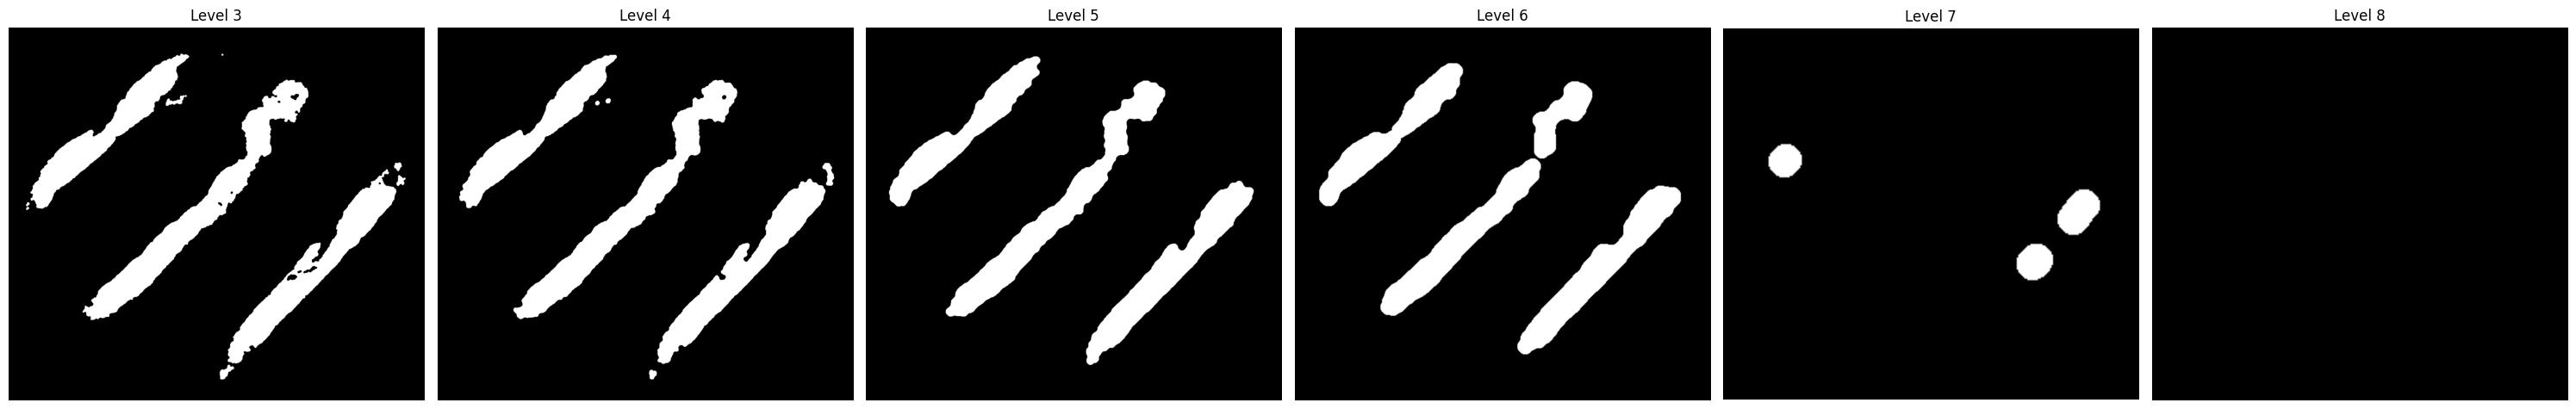

In [3]:
import matplotlib.pyplot as plt
import pyvips
from openslide import OpenSlide
from rationai.visualization.mask_generation import tissue_mask
from rationai.visualization import write_big_tiff
from pathlib import Path


def tissue_mask_level(slide_path: Path, level: int) -> pyvips.Image:
    # TODO:
    #   1. load the WSI from `slide_path` on desired level
    #   2. create the tissue mask
    #   3. return thumbnail with fixed max width, e.g. 2000
    slide = pyvips.Image.new_from_file(slide_path, page=level)
    mask = tissue_mask(slide=slide)
    thumbnail = mask.thumbnail_image(2000)
    return thumbnail

def all_level_masks(slide_path: Path) -> None:
    with OpenSlide(slide_path) as slide:
        slide_levels = range(slide.level_count)[
            3:
        ]  # DO NOT GENERATE MASKS FOR LOWER LEVELS THAN 3

    n_slide_levels = len(slide_levels)

    # Create subplots with one row and as many columns as slide levels
    fig, axes = plt.subplots(1, n_slide_levels, figsize=(5 * n_slide_levels, 5))

    for level in slide_levels:
        mask = tissue_mask_level(slide_path, level)

        # Convert pyvips Image to NumPy array for plotting
        mask_np = mask.numpy()

        # Plot on the corresponding axis
        ax = axes[level - 3]  # Index from 0
        ax.imshow(mask_np, cmap="gray")
        ax.set_title(f"Level {level}")
        ax.axis("off")  # Turn off axis

    plt.tight_layout()
    plt.show()


all_level_masks(SLIDE_PATH)

Once you have determined the appropriate level for generating tissue masks, you're ready to begin the process.

<style>
code {
    color: purple;
    background-color: #f0f0f0;
}
</style>

<div class="alert alert-success">
    <h3>TASK 4.02</h3>
    <p>
        Your task is to complete the <code>generate_tissue_mask</code> function and run the tissue mask generation for all slides <strong>concurrently</strong>. To avoid wasting computational resources, do not process all slides. Instead, use the <code>SAMPLE_SLIDES</code> variable, which contains a single element slice.
    </p>
    <p>
        Remember, there’s no need to create your own solution from scratch. Instead, refer to our <a href="https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/visualization">Visualization library</a> for pre-built functions.
    </p>
    <p>
        For the final step, where you process all slides, ensure that you use concurrent task processing to speed up computation. You can either use our provided methods or visit the <a href="https://docs.ray.io/en/latest/">Ray documentation</a> for guidance on concurrent processing.
    </p>
</div>


In [4]:
from pathlib import Path
import ray
from rationai.visualization.processing import process_items

TISSUE_MASK_LEVEL = 3
TISSUE_MASK_DEST = "data/tissue_masks"

SAMPLE_SLIDES = [
    SLIDE_PATH
]  # We will be only working with a single slide for demonstration


def generate_tissue_mask(slide_path: Path) -> None:
    # TODO:
    #   1. load the WSI from `SLIDE_PATH` on desired level
    #   2. create the tissue mask
    #   3. generate mask file name (`stem` from `Path` might be useful)
    #   4. store the mask as BigTIFF (write_big_tiff from rationai.visualization)
    
    slide = pyvips.Image.new_from_file(slide_path, page=TISSUE_MASK_LEVEL)
    assert isinstance(slide, pyvips.Image)
    mask = tissue_mask(slide=slide)
    f_name = Path(f"{TISSUE_MASK_DEST}/{Path(slide_path).stem}_tissue_mask.tiff")
    print(f_name)
    write_big_tiff(mask, f_name)


# TODO: Process the slides concurently

process_items(SAMPLE_SLIDES, generate_tissue_mask, max_concurrent=10)


  0%|          | 0/1 [00:00<?, ?it/s]2024-09-05 15:25:05,887	WARNING services.py:2017 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-09-05 15:25:07,011	INFO worker.py:1783 -- Started a local Ray instance.


(generate_tissue_mask pid=8466) data/tissue_masks/S16-00356_tissue_mask.tiff


100%|██████████| 1/1 [00:12<00:00, 12.07s/it]


To verify that your computed masks are correct, you can visualize them by calling `display_BigTIFF` function.


In [5]:
import pyvips
from PIL import Image


# Helper function for displaying images
def display_mask_image(image: pyvips.Image) -> None:
    img = image.thumbnail_image(10000)
    display(Image.fromarray(img.numpy()))


def display_BigTIFF(path: Path | str, level: int = 0):
    slide = pyvips.Image.thumbnail(path, 10000)
    display(Image.fromarray(slide.numpy()))


display_BigTIFF(f"{TISSUE_MASK_DEST}/{Path(SLIDE_PATH).stem}_tissue_mask.tiff", level=0)  # TODO: Change the path

You’ve successfully completed the first step of data preprocessing. Now, there are a few more steps to finalize the preprocessing of your data.

### Step 2: Creating a Binary Annotation Mask 🗺️

Next important step is to create **annotation masks**. The dataset provides annotations in XML format, which need to be converted into **binary masks**. These binary masks will highlight the regions of interest (ROIs) in the slides, where:

- **White (1)** represents the annotated regions of interest.
- **Black (0)** represents areas outside the annotations.

To create these annotation masks, you need to parse the XML annotations to extract the regions of interest.

The [Visualization](https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/visualization) library exports a class `PolygonMask` that could help with that. To adapt it to our needs, you will need to:
**Subclass `PolygonMask`** and adjust the methods to handle the specific style of XML annotations provided in the dataset.

<style>
.code {
    code {
        color: purple;
        background-color: #f0f0f0;
    }
}

</style>

<div class="alert alert-success code">
    <h3>TASK 4.03</h3>
    <p>
        Fill the missing code in <code>AnnotationMask</code>, the rest is almost identical to previous task.
    </p>
</div>


The XML Annotations have following structure:


In [7]:
<Annotations MicronsPerPixel="0.498600">
	<Annotation ...>
		<Attributes>
			<Attribute Name="Tumor" Id="0" Value="Tumor" />
		</Attributes>
		<Regions>
			<Region ...>
				<Vertices>
					<Vertex X="3968" Y="11968" Z="0" />
                    ...
					<Vertex X="3968" Y="11968" Z="0" />
				</Vertices>
			</Region>
            ...
			<Region ...>
				<Vertices>
					<Vertex X="8936" Y="15332" Z="0"/>
                    ...
                    <Vertex X="8936" Y="15332" Z="0"/>
				</Vertices>
			</Region>
		</Regions>
	</Annotation>
</Annotations>


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 10)

In [19]:
from pathlib import Path
from xml.etree import ElementTree as ET

from rationai.visualization.mask_generation import PolygonMask


class AnnotationMask(PolygonMask):
    def get_annotation_element_path(self) -> str:
        return "Annotation/Regions/Region"  
        # TODO: examine the annotations XML and fill the string
        # You should fill the path towards the list of all Regions
        # Form: element1/element2/element3

    def get_annotation_element_keyword(self, annotation_tag: ET.Element) -> str | None:
        return annotation_tag.get("PartOfGroup")

    def get_coordinate_element_path(self) -> str:
        return "Vertices/Vertex"  
        # TODO: examine the annotations XML and fill the string
        # You are already iterating over individual Regions, fill path towards vertices
        # Form: element1/element2/element3


ANNOTATION_MASK_DEST = Path("data/annotation_masks")
ANNOTATION_MASK_DIR = Path("/mnt/data/BreastCancer/Annotations")


def generate_annotation_mask(slide_path: Path) -> None:
    # TODO:
    #   1. create mask
    #   2. generate mask path
    #   3. save mask (you need to transform the mask from PIL.Image to pyvips.Image)
    path = ANNOTATION_MASK_DEST / f"{slide_path.stem}_annotation.xml"
    mask = AnnotationMask(slide_path, ANNOTATION_MASK_DIR, TISSUE_MASK_LEVEL, None, None)
    image = pyvips.Image.new_from_array(mask())
    write_big_tiff(image, path) # to do 3.


# TODO: Process the slides concurently
process_items(
    SAMPLE_SLIDES,
    generate_annotation_mask,
    max_concurrent=10
)

100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


In [25]:
path = ANNOTATION_MASK_DEST / f"{SAMPLE_SLIDES[0].stem}_annotation.xml"
display_BigTIFF(
     path, level=0
)  # TODO: Change the path to view generated annotation mask

### Step 3: Tile the Dataset 🧩

Now that we’ve created both **tissue masks** and **annotation masks**, the next step is to **tile** the data. Tiling breaks large WSIs into smaller, more manageable sections that can be processed efficiently by machine learning models. It’s important to note that the tiling process doesn’t generate new images. Instead, it creates a **meta-dataset**, which references the original WSIs.

The tiler creates two key meta-datasets:

1. **Slide-level meta-dataset**: This contains information about the entire slide, such as the file path, the processing level, processed slide dimensions, and tile size.
2. **Tile-level meta-dataset**: This dataset stores details about individual tiles, such as their starting x and y coordinates. This allows you to efficiently read only the relevant regions from the WSIs.

Before you continue, take a moment to review the [Tiler documentation](https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/tiling) to understand how the tool works. Reflect on how tiling fits into your data preprocessing pipeline:

- **What is the goal?** The aim is to create smaller image patches while preserving important tissue and annotated regions.
- **How do you use the masks?** The tissue and annotation masks will guide the tiling process, ensuring that only relevant regions of interest are selected for tiling.

By following this process, you’ll ensure that your model focuses on meaningful data, improving its efficiency and accuracy for training.

To control how the tiles are processed, we need to define filters and annotators. These will allow us to:

1. **Filter out** tiles that don't contain enough tissue.
2. **Annotate** tiles based on their overlap with the annotation mask.

<style>
code {
    color: purple;
    background-color: #f0f0f0;
}
</style>

<div class="alert alert-success">
    <h3>TASK 4.04</h3>
    <p>
        At first, you need to define the filters/annotators which dictate how to process each slide and its corresponding tiles:
        <ol>
            <li><code>TissueFilter</code> that removes tiles that don’t overlap significantly with tissue. (At least 50 %).</li>
            <li><code>CancerCoverage</code> that computes the intersection of tiles with the annotation mask.</li>
        </ol>
        Once the filters/annotators are defined, you need to specify the Reader. For this task go with the <code>OpenslideReader</code> from the tiling library.<br>
        Set the `tile_size` to 512 and stride to 256. We recomend tiling the dataset either on level 1 or 0.
    </p>
    <p>
        Finally, you are ready to run the tiler on the sample subset of slides to tile the dataset.
    </p>
</div>


In [ ]:
from rationai.tiling.annotators import NumpyMaskFilter
from rationai.tiling.typing import SlideLabels, TileLabels


class TissueFilter(NumpyMaskFilter):
    def __init__(
        self, slide_labels: SlideLabels, tiles_labels: list[TileLabels]
    ) -> None:
        slide_name = Path(slide_labels["path"]).name
        mask_path = Path(TISSUE_MASK_DEST, slide_name)
        mask = np.load(Path(slide_labels["path"]).with_suffix(".npy"), mmap_mode="r")
        super().__init__(
            self.mask=mask,
            self.coverage=(0.5, 1.0),
            self.slide_labels=slide_labels,
            self.tiles_labels=tiles_labels
        )


class CancerCoverage(NumpyMaskFilter):
    def __init__(
        self, slide_labels: SlideLabels, tiles_labels: list[TileLabels]
    ) -> None:
        slide_name = Path(slide_labels["path"]).name
        mask_path = Path(ANNOTATION_MASK_DEST, slide_name)
        mask = pyvips.Image.new_from_file(mask_path, page=0).numpy()
        super().__init__(
            mask,
            slide_labels=slide_labels,
            tiles_labels=tiles_labels,
            coverage_name="cancer_coverage",
        )


reader = OpenslideReader(level=1, tile_size=512, stride_size=256)
annotators = [TissueFilter, CancerCoverage]

slides_df, tiles_df = tiling(slides=SAMPLE_SLIDES, reader=reader, annotators=annotators)

### Checking Tiling Results 🧩➡️🔍

To verify that the tiling process produced the expected tiles, you can visualize the tiles as boxes, unfortunately not overlaid over the original image. Use the following function to visualize the tiles:


In [ ]:
from typing import Any

from rationai.visualization.mask_generation import tile_mask


def display_slide_tiles(slide: Any) -> None:
    slide_tiles = tiles_df[tiles_df["slide_path"] == slide.path]
    mask = tile_mask(
        slide_tiles,
        slide.tile_height,
        slide.tile_width,
        slide_dimensions=(slide.slide_width, slide.slide_height),
    )
    display_mask_image(pyvips.Image.new_from_array(mask))


display_slide_tiles(
    list(slides_df.itertuples())[0]
)  # Display the tile mask for the first slide

If everything looks good with the tiled dataset, the next step is to save it for further use.

### Saving the Dataset to MLflow 💾

We will store the processed dataset in **MLflow** for easier tracking, versioning, and future accessibility.

<div class="alert alert-success">
    <h3>TASK 4.05</h3>
    <p>
        To upload the dataset to MLflow, follow these steps:
        <ol>
            <li>Open <a href="https://biomedai-summer-mlflow.dyn.cloud.e-infra.cz/">MLflow</a> and log in using the credentials we sent to you via email.</li>
            <li>In MLflow, navigate to the <b>Experiment menu</b> and click the plus button to create your own experiment. (<b>Be sure to name the experiment with your own name</b>.)</li>
            <li>Finalize the missing code for uploading your dataset to MLflow. If you see any warnings about missing values during upload stage, you can ignore them for now</li>
            <li>Once you've successfully uploaded the dataset, you can view it under your experiment. The data itself will be stored as artifacts in <b>parquet</b> format, and you can find a brief description of your dataset under the `Datasets used` section in MLflow</li>
        </ol>
    </p>
</div>

By completing these steps, you'll have your dataset logged in MLflow, making it easier to track and manage for future analysis.


In [ ]:
%env MLFLOW_TRACKING_USERNAME= ...
%env MLFLOW_TRACKING_PASSWORD= ...

In [ ]:
import mlflow

MLFLOW_URI = "https://biomedai-summer-mlflow.dyn.cloud.e-infra.cz/"
EXPERIMENT_NAME = ".." # TODO Fill with your experiment


mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

with mlflow.start_run(run_name="...") as _: # TODO: Name your run
    # TODO Save the dataset to MLflow using save_mlflow_dataset function from rationai.tiling

### Congratulations! 🎉

Well done, you've successfully created a **Meta Dataset** that can be used alongside the original WSIs to train a neural network.
In the next part, we will explore how to **load and interact with the dataset** you just created, so you can use it in your neural network training process.

## 5. WSI Dataset 🧠

---

In this section, we will create PyTorch and Lightning datasets and datamodules that allow us to work with the tiles from our WSIs efficiently. The first step is to create a dataset for a **single slide**, which will iterate over its **tiles**. We will achieve this by subclassing the `SlideTiles` dataset from our [MLkit library](https://gitlab.ics.muni.cz/rationai/digital-pathology/libraries/mlkit).

Unfortunately, the `MLkit` library currently lacks proper documentation...

<div class="alert alert-success">
    <h3>TASK 3.01</h3>
    <p>
        Fill in the missing code to create a PyTorch dataset for a single slide. You can find inspiration from <b>Notebook 1</b>. If you're unsure about the labeling part, feel free to proceed to the next task, which will hopefully provide further clarification.
    </p>
</div>


In [ ]:
import pandas as pd
import torch
from albumentations import TransformType
from albumentations.pytorch import ToTensorV2
from rationai.mlkit.data import SlideTiles


class BreastCancerSlideTiles(SlideTiles):
    def __init__(
        self, slide_labels, tiles: pd.DataFrame, transforms: TransformType | None = None
    ) -> None:
        super().__init__(slide_labels=slide_labels, tiles=tiles)
        self.transforms = transforms
        self.to_tensor = ToTensorV2()

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        image = # TODO: call parent class __getitem__ which returns just desired image
        label = # TODO: retrieve relevant row from tiles (use iloc function), select "cancer"
                # column wich will denote the presence of cancer (boolean)
                # This column will be added to our tiles in the next step

        # TODO: apply transforms just like in notebook 1

        return # TODO: (image, label) transformed to tensors. Note, prior transforming the label
               # wrap it to list -> [label] to ensure consistent dimensionality

### Next Step: Combining Single Slide Datasets 🧩

Now that you've created a dataset for a single slide using `SlideTiles`, we will move on to the next step: creating a **ConcatDataset**. This dataset will combine all individual **single slide datasets** (i.e., `BreastCancerSlideTiles`) into one large dataset, making it easier to train your neural network on multiple slides at once.

Instead of using the original `ConcatDataset`, we will use a subclass from the MLkit library called `MLFlowSlides`. This subclass not only concatenates the datasets but also includes logic for downloading the dataset from MLflow.
With `MLFlowSlides`, you'll have a comprehensive dataset that’s ready to be used for training your model across multiple WSIs.


In [ ]:
from collections.abc import Iterable

import mlflow
from albumentations import TransformType
from rationai.mlkit.data import MLFlowSlides
from torch.utils.data import Dataset


class BreastCancer(MLFlowSlides):
    def __init__(
        self,
        uris: list[str],
        cancer_threshold: float,
        transforms: TransformType | None = None,
    ) -> None:
        self.transforms = transforms
        self.cancer_threshold = cancer_threshold
        super().__init__(uris)

    def generate_datasets(self) -> Iterable[Dataset]:
        # If the overlap with the annotation mask e.g. (cancer_coverage) exceeds the threshold,
        # we set the tile to be positive (contains cancer) otherwise negative
        self.tiles["cancer"] = self.tiles["cancer_coverage"] > self.cancer_threshold
        # TODO: You may have named the column differently (this was generated during the tiling process
        # with the CancerCoverage filter/annotation class)

        return (
            BreastCancerSlideTiles(
                slide, self.filter_tiles_by_slide(slide.path), self.transforms
            )
            for slide in self.slides.itertuples()
        )


### Demonstration: DataModule with Batch Stratification in DataLoader 📊

In this section, we will demonstrate how to use **Batch Stratification** with your DataLoader to ensure that each batch of data has a consistent distribution of classes. This is particularly important when dealing with imbalanced datasets, as it helps in training a more robust model.

#### What is Batch Stratification?

**Batch Stratification** ensures that each batch of data contains a representative sample of all classes, rather than random samples that might skew the class distribution. This technique is crucial for models that are sensitive to class imbalance, as it helps the model learn from a balanced set of examples in each training iteration.

#### Our Custom Batch Sampler: `PDMStratifiedBatchSampler`

For this purpose, we use a custom class called `PDMStratifiedBatchSampler`, which stands for **Pandas DataFrame Multi-class Batch Sampler**. This sampler is designed to handle batch stratification based on a Pandas DataFrame containing your dataset's labels.

Here’s a code snippet demonstrating how to use `PDMStratifiedBatchSampler` with DataLoader within a DataModule:


In [ ]:
from collections.abc import Iterable

from hydra.utils import instantiate
from lightning import LightningDataModule
from omegaconf import DictConfig
from rationai.mlkit.data.stratified_batch_sampler import PDMStartifiedBatchSampler
from torch.utils.data import DataLoader


class DataModule(LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        num_workers: int = 0,
        **datasets: DictConfig,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.datasets = datasets

    def setup(self, stage: str) -> None:
        match stage:
            case "fit":
                self.train = instantiate(self.datasets["train"])

    def train_dataloader(self) -> Iterable[tuple[torch.Tensor, torch.Tensor]]:
        return DataLoader(
            self.train,
            batch_sampler=PDMStartifiedBatchSampler(  # Ensures that each batch will have consistent ration of non-cancerous and cancerous tiles (inputs)
                self.train.tiles,
                stratify_by=self.train.tiles[
                    "cancer"
                ],  # "Splits" dataset into two parts, one with tiles marked as cancer, other with non-cacner tiles
                batch_size=self.batch_size,
            ),
            num_workers=self.num_workers,
            persistent_workers=self.num_workers > 0,
        )

## 6.


## 6. Wrap It Up! 🎯

---

With the knowledge gained from this and the previous notebooks, you are now equipped to complete your project: building a neural network to classify regions containing cancer in the BreastCancer (HER2) dataset. Here’s your final task:

- **Recycle**: Utilize and adapt as much as possible from the **Patch Camelyon** model.
- **Modify**: Adjust the `DataModule` and datasets.
- **Add Augmentations**: Implement data augmentations to improve your model’s performance.
- **Submit for Training**: Once everything is set up, submit your job for training.

**Do not tile your own dataset!** Intead donwload the dataset stored in MLflow under **Breast Cancer Dataset** experiment which is already split to trainig, test and validation sets. The URI towards each dataset can be copied from MLflow under **Artifacts** section within given run. (Copy the **directory** path, not the path towards individual **parquets**.)

Good luck with your project, and make the most of what you’ve learned! 🚀
